In [1]:
import pandas as pd
import dash
from dash import dcc, html
import dash_daq as daq

import numpy as np
import psycopg2
import pyodbc
import mysql.connector
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
from decimal import Decimal

import datetime
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [2]:
# Redshift 연결 정보
host=''
dbname=''
user=''
password=''
port=''

In [3]:
# Redshift에 연결
conn = psycopg2.connect(
    host=host,
    dbname=dbname,
    user=user,
    password=password,
    port=port
)

In [4]:
# 커서 생성
cursor = conn.cursor()
# SQL 쿼리 실행 (예시: frigga_sample 테이블에서 모든 데이터를 조회)
cursor.execute("""                          
                    SELECT 
                        *
                    FROM 
                        "data_analysis_db"."da_schema"."t_frigga_broken_target"
                    WHERE 1=1
                    ORDER BY device_serial ASC
                ;
               """)

# 결과 가져오기
rows = cursor.fetchall()

# 컬럼명 가져오기
columns = [desc[0] for desc in cursor.description]

# DataFrame으로 변환
broken = pd.DataFrame(rows, columns=columns)

# 커서와 연결 종료
cursor.close()
conn.close()

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [6]:
# 독립변수 / 종속변수 구분# 독립 변수와 종속 변수 정의
X = broken[['duration_time', 'duration_day', 'min_temp', 'max_temp', 'mean_temp', 'std_temp', 'min_humi', 'max_humi', 'mean_humi', 'std_humi', 
                'min_acc', 'max_acc', 'mean_acc', 'std_acc', 'q1_temp', 'q3_temp', 'temp_start', 'temp_end', 'q1_humi', 'q3_humi', 
                'humi_start', 'humi_end', 'q1_acc', 'q3_acc', 'acc_start', 'acc_end', 'ta_min', 'ta_max', 'ta_mean', 'ta_std', 
                'ta_q1', 'ta_q3', 'ws1_min', 'ws1_max', 'ws1_mean', 'ws1_std', 'ws1_q1', 'ws1_q3', 'ws10_min', 'ws10_max', 
                'ws10_mean', 'ws10_std', 'ws10_q1', 'ws10_q3', 'hm_min', 'hm_max', 'hm_mean', 'hm_std', 'hm_q1', 'hm_q3', 
                'alert_temp_sum', 'alert_humi_sum', 'alert_acc_sum']]

# y = df_broken['broken_yn']
y = broken['broken_yn'].astype(int)

정확도: 0.9375
ROC AUC 점수: 1.0000
분류 보고서:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        25
           1       0.78      1.00      0.88         7

    accuracy                           0.94        32
   macro avg       0.89      0.96      0.92        32
weighted avg       0.95      0.94      0.94        32



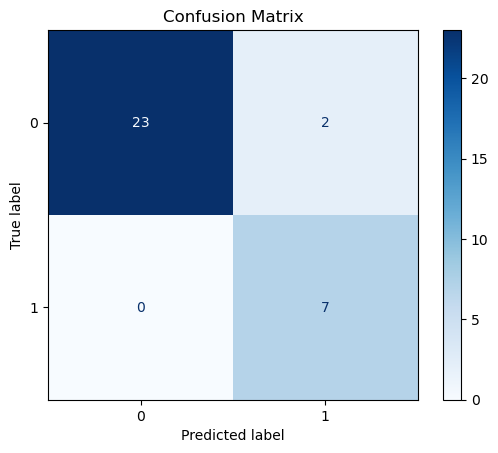

    broken_yn  predicted_proba
0           0              NaN
1           1              NaN
2           1              NaN
3           0              NaN
4           0              NaN
..        ...              ...
151         0              NaN
152         0         0.033635
153         0              NaN
154         1              NaN
155         0              NaN

[156 rows x 2 columns]


In [7]:
# 데이터 분할 (훈련 세트와 테스트 세트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # 훈련 세트에 맞춰 스케일링
X_test_scaled = scaler.transform(X_test)  # 테스트 세트에 동일한 스케일링 적용

# 로지스틱 회귀 모델 생성
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test)
y_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]  # 클래스 1에 대한 확률

# 예측 결과 평가
y_pred_lr = lr_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred_lr)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# 결과 출력
print(f"정확도: {accuracy:.4f}")
print(f"ROC AUC 점수: {roc_auc:.4f}")
print("분류 보고서:")
print(classification_report(y_test, y_pred_lr))

# Confusion Matrix 계산
cm = confusion_matrix(y_test, y_pred_lr)

# Confusion Matrix 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# 예측 확률을 데이터프레임에 추가
X_test_with_proba = X_test.copy()  # X_test의 복사본 생성
X_test_with_proba['predicted_proba'] = y_pred_proba  # 새로운 컬럼 추가

# 원래 데이터프레임에 추가 (원하는 경우)
df_broken_prob = broken.copy()  # 원본 데이터프레임 복사
df_broken_prob.loc[X_test.index, 'predicted_proba'] = y_pred_proba  # 예측 확률 추가

# 결과 확인
print(df_broken_prob[['broken_yn', 'predicted_proba']])

### Dash Board 예시 만들기

In [8]:
import dash
from dash import dcc, html
import plotly.graph_objects as go
import pandas as pd
import numpy as np

In [47]:
# Dash 애플리케이션 초기화
app = dash.Dash(__name__)

# 데이터 생성
total_items = 2000
normal_items = 1800
damaged_items = 200

# 파손 비율 데이터
labels = ['Normal', 'Damaged']
values = [normal_items, damaged_items]

# 로지스틱 회귀 예측 결과 (예시)
predicted_probability = 0.65  # 예시 확률값

# 온도 및 습도 데이터 생성 (2025년 01월 03일부터 2025년 02월 23일까지)
date_range = pd.date_range(start='2025-01-03', end='2025-02-23')
temperature_data = np.random.uniform(low=-10, high=-5, size=len(date_range) - 1).tolist()
temperature_data.append(-12)  # 일탈 케이스 추가
np.random.shuffle(temperature_data)  # 일탈 케이스를 랜덤하게 섞기
humidity_data = np.random.uniform(low=30, high=70, size=len(date_range))  # 습도 데이터 생성
temperature_df = pd.DataFrame({'Date': date_range, 'Temperature': temperature_data, 'Humidity': humidity_data})

# 충격량 데이터 생성 (2025년 01월 03일부터 2025년 02월 23일까지)
shock_data = np.random.uniform(low=0.0, high=2.0, size=len(date_range)).tolist()
shock_data[-1] = 2.5  # 마지막 값을 일탈 케이스로 설정
np.random.shuffle(shock_data)  # 일탈 케이스를 랜덤하게 섞기
shock_df = pd.DataFrame({'Date': date_range, 'Shock': shock_data})


# 향후 일주일치 예측값 (임의로 생성, 정상 범위로 설정)
future_dates = pd.date_range(start='2025-02-24', periods=7)
future_temperatures = np.random.uniform(low=-10, high=-5, size=len(future_dates))
future_humidity = np.random.uniform(low=30, high=70, size=len(future_dates))
future_temperature_df = pd.DataFrame({'Date': future_dates, 'Temperature': future_temperatures, 'Humidity': future_humidity})

# 온도 일탈 알림 생성
anomalies = temperature_df[(temperature_df['Temperature'] < -10) | (temperature_df['Temperature'] > -5)]
anomaly_alert_dates = anomalies['Date'].tolist()  # 일탈 발생 날짜 리스트

# 충격량 일탈 알림 생성
shock_anomalies = shock_df[shock_df['Shock'] > 2.0]
shock_anomaly_alert_dates = shock_anomalies['Date'].tolist()  # 일탈 발생 날짜 리스트

damage_rate = (damaged_items / total_items) * 100  # 파손 비율 계산


# 대시보드 레이아웃 설정
app.layout = html.Div([
    html.H1("물품 파손 관련 대시보드"),
    
    # KPI 표시
    html.Div([
        html.H2("KPI 지표"),
        html.P(f"총 물품 수: {total_items}개", style={'font-size': '20px'}),
        html.P(f"파손된 물품 수: {damaged_items}개", style={'font-size': '20px'}),
        html.P(f"파손 비율: {damage_rate:.2f}%", style={'font-size': '20px', 'color': 'red' if damage_rate > 10 else 'green'})
    ], style={'margin-top': '20px', 'padding': '20px', 'border': '1px solid #ccc', 'border-radius': '5px'}
    ),
    
    
    # 파이 차트
    dcc.Graph(
        id='damage-pie-chart',
        figure=go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)]).update_layout(title='물품 파손 비율'),
        style={'width': '48%', 'display': 'inline-block'}  # 그래프 48% 크기, 가로로 나란히
    ),
    
    # 게이지 차트
    dcc.Graph(
        id='gauge-chart',
        figure=go.Figure(go.Indicator(
        mode="gauge+number",
        value=predicted_probability,
        title={'text': "파손 예측 확률"},       
        gauge={
                'axis': {'range': [0, 1]},
                'bar': {'color': "blue"},
                'steps': [
                    {'range': [0, 0.3], 'color': "green"},  # 안전
                    {'range': [0.3, 0.7], 'color': "yellow"},  # 주의
                    {'range': [0.7, 1], 'color': "red"}  # 위험
                ],
                'threshold': {
                    'line': {'color': "red", 'width': 4},
                    'thickness': 0.75,
                    'value': 0.7  # 위험 경계
                }
            }
        )),
        style={'width': '48%', 'display': 'inline-block'}  # 그래프 48% 크기, 가로로 나란히    

    ),    
    
# 온도 및 습도 라인 차트
    html.Div([
        dcc.Graph(
            id='temperature-line-chart',
            figure=go.Figure()
                .add_trace(go.Scatter(
                    x=temperature_df['Date'], 
                    y=temperature_df['Temperature'], 
                    mode='lines+markers', 
                    name='과거 온도',
                    marker=dict(color='blue')
                ))
                .add_trace(go.Scatter(
                    x=future_temperature_df['Date'], 
                    y=future_temperature_df['Temperature'], 
                    mode='lines+markers', 
                    name='예측 온도', 
                    line=dict(dash='dash'),
                    marker=dict(color='orange')
                ))
                .add_trace(go.Scatter(
                    x=anomaly_alert_dates, 
                    y=[-12] * len(anomaly_alert_dates),  # 일탈 온도
                    mode='markers+text', 
                    name='온도 일탈', 
                    marker=dict(color='red', size=10, symbol='x'),
                    text=['온도 일탈'] * len(anomaly_alert_dates),  # 팝업 텍스트
                    textposition='top center'
                ))
                .update_layout(title='온도 측정', xaxis_title='날짜', yaxis_title='온도 (°C)')
        ),
        
        dcc.Graph(
            id='humidity-line-chart',
            figure=go.Figure()
                .add_trace(go.Scatter(
                    x=temperature_df['Date'], 
                    y=temperature_df['Humidity'], 
                    mode='lines+markers', 
                    name='과거 습도',
                    marker=dict(color='green')
                ))
                .add_trace(go.Scatter(
                    x=future_temperature_df['Date'], 
                    y=future_humidity, 
                    mode='lines+markers', 
                    name='예측 습도', 
                    line=dict(dash='dash'),
                    marker=dict(color='lightgreen')
                ))
                .update_layout(title='습도 측정', xaxis_title='날짜', yaxis_title='습도 (%)')
        )
        ], style={'display': 'flex', 'flex-direction': 'column', 'gap': '20px', 'margin-top': '20px', 'padding': '20px'}),  # 그리드 레이아웃 설정
        
         # 충격량 라인 차트 추가
        dcc.Graph(
        id='shock-line-chart',
        figure=go.Figure()
            .add_trace(go.Scatter(
                x=shock_df['Date'], 
                y=shock_df['Shock'], 
                mode='lines+markers', 
                name='충격량',
                marker=dict(color='purple')
            ))
            .add_trace(go.Scatter(
                x=shock_anomaly_alert_dates, 
                y=[2.5] * len(shock_anomaly_alert_dates),  # 일탈 충격량
                mode='markers+text', 
                name='충격량 일탈', 
                marker=dict(color='red', size=10, symbol='x'),
                text=['충격량 일탈'] * len(shock_anomaly_alert_dates),  # 팝업 텍스트
                textposition='top center'
            ))
            .update_layout(title='충격량 측정', xaxis_title='날짜', yaxis_title='충격량')
        )
])

# 서버 실행
if __name__ == '__main__':
    app.run_server(debug=True)